In [57]:
import ast
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import axelrod as axl
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score, roc_auc_score, hamming_loss, accuracy_score


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (
    precision_recall_fscore_support,
    multilabel_confusion_matrix
)


In [58]:
import xgboost as xgb


In [59]:
strategy_data_path = '../simulated_data/precalculated_metrics/all_strategy_metrics.csv'


strategy_df = pd.read_csv(strategy_data_path)
strategy_df['strategy_name'] = strategy_df['strategy_name'].str.strip()
strategy_df.fillna(0, inplace=True)



In [60]:
strategy_metrics = {}
for idx, row in strategy_df.iterrows():
    strategy_metrics[row['strategy_name']] = row[['Niceness','Retaliation','Forgiveness','OverallCoop','AvgPayoff']].to_dict()
strategy_metrics

{'AON2': {'Niceness': 1.0,
  'Retaliation': 0.9048521929553368,
  'Forgiveness': 0.0,
  'OverallCoop': 0.7136381578947368,
  'AvgPayoff': 2.780519736842105},
 'APavlov2006': {'Niceness': 1.0,
  'Retaliation': 0.9390716795754448,
  'Forgiveness': 0.6761810193666269,
  'OverallCoop': 0.7605460526315789,
  'AvgPayoff': 2.685269736842105},
 'APavlov2011': {'Niceness': 1.0,
  'Retaliation': 0.8813740142375256,
  'Forgiveness': 0.7037723127823626,
  'OverallCoop': 0.7787105263157895,
  'AvgPayoff': 2.683236842105263},
 'Adaptive': {'Niceness': 1.0,
  'Retaliation': 0.0824213218120346,
  'Forgiveness': 0.0673076923076923,
  'OverallCoop': 0.496781954887218,
  'AvgPayoff': 2.2391870300751884},
 'AdaptiveTitForTat': {'Niceness': 1.0,
  'Retaliation': 0.9346153846153846,
  'Forgiveness': 1.0,
  'OverallCoop': 0.8340404135338345,
  'AvgPayoff': 2.7257857142857147},
 'Aggravater': {'Niceness': 0.0,
  'Retaliation': 1.0,
  'Forgiveness': 0.0,
  'OverallCoop': 0.0897744360902255,
  'AvgPayoff': 1.86

In [61]:
strategies = [axl.Raider(),axl.Cooperator(), axl.GrudgerAlternator(), axl.EvolvedANNNoise05(), axl.Forgiver()]


In [62]:
strategy_order = [player.__class__.__name__ for player in strategies]

strategy_mapping = {name: player.__class__ for name, player in zip(strategy_order, strategies)}

strategy_mapping

{'Raider': axelrod.strategies.finite_state_machines.Raider,
 'Cooperator': axelrod.strategies.cooperator.Cooperator,
 'GrudgerAlternator': axelrod.strategies.grudger.GrudgerAlternator,
 'EvolvedANNNoise05': axelrod.strategies.ann.EvolvedANNNoise05,
 'Forgiver': axelrod.strategies.forgiver.Forgiver}

In [63]:
df_experiments = pd.read_csv('../simulated_data/simulated_tournamets/5_setup_data.csv')

In [64]:
print(df_experiments.head())

   Unnamed: 0      composition   coop_rate  \
0           0  [0, 2, 1, 2, 5]  162.660000   
1           1  [1, 1, 3, 3, 0]  145.656250   
2           2  [5, 5, 1, 5, 5]  127.369615   
3           3  [0, 1, 3, 0, 4]  200.000000   
4           4  [2, 1, 1, 0, 2]  113.277778   

                                  winning_strategy  
0                            ['GrudgerAlternator']  
1                                       ['Raider']  
2                            ['EvolvedANNNoise05']  
3  ['Cooperator', 'GrudgerAlternator', 'Forgiver']  
4                                       ['Raider']  


In [65]:
df_experiments['winning_strategy'] = df_experiments['winning_strategy'].apply(ast.literal_eval)
df_experiments['composition'] = df_experiments['composition'].apply(ast.literal_eval)



In [66]:
def build_tournament_feature_matrix(record, strategy_order, strategy_metrics):
    comp = record['composition']
    features = []
    for strat_name, count in zip(strategy_order, comp):
        if int(count) > 0:
            m = strategy_metrics.get(strat_name,
                                     {'Niceness':0, 'Retaliation':0, 'Forgiveness':0, 'OverallCoop':0, 'AvgPayoff':0})
            row = [count, m['Niceness'], m['Retaliation'], m['Forgiveness'], m['OverallCoop'], m['AvgPayoff']]
        else:
            row = [0, 0, 0, 0, 0, 0]
        features.append(row)
    return np.array(features)

tournament_features = []
for idx, row in df_experiments.iterrows():
    mat = build_tournament_feature_matrix(row, strategy_order, strategy_metrics)
    tournament_features.append(mat.flatten())



In [67]:
print(len(tournament_features[0]))

30


In [68]:
X = np.array(tournament_features)
coop_rate = df_experiments['coop_rate'].values.reshape(-1, 1)
print(df_experiments['winning_strategy'].value_counts())
X = np.concatenate([X, coop_rate], axis=1)
print("Final feature shape (each sample flattened):", X.shape)

winning_strategy
[Raider]                                     2543
[EvolvedANNNoise05]                          1460
[GrudgerAlternator]                           461
[Forgiver]                                    344
[Cooperator, GrudgerAlternator, Forgiver]      88
[Cooperator]                                   31
[Cooperator, Forgiver]                         18
[GrudgerAlternator, Forgiver]                  18
[Cooperator, GrudgerAlternator]                16
[Raider, EvolvedANNNoise05]                    11
[Raider, GrudgerAlternator]                     6
[Raider, Forgiver]                              4
Name: count, dtype: int64
Final feature shape (each sample flattened): (5000, 31)


In [69]:
mlb = MultiLabelBinarizer()
y_multi = mlb.fit_transform(df_experiments['winning_strategy'])
print("Multi-label target shape:", y_multi.shape)
print("Classes (winning strategies):", mlb.classes_)

Multi-label target shape: (5000, 5)
Classes (winning strategies): ['Cooperator' 'EvolvedANNNoise05' 'Forgiver' 'GrudgerAlternator' 'Raider']


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [71]:

from sklearn.multiclass import OneVsRestClassifier

dt_clf = OneVsRestClassifier(DecisionTreeClassifier(random_state=42, max_depth=5))
dt_clf.fit(X_train, y_train)
rf_clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=300, random_state=42))
rf_clf.fit(X_train, y_train)
import xgboost as xgb
xgb_clf = OneVsRestClassifier(xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
xgb_clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [03:28:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...))

In [72]:
from tensorflow.keras.regularizers import l2
nn_model = Sequential([
    Dense(32, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
nn_model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2226 - loss: 0.7478 - val_accuracy: 0.7175 - val_loss: 0.4914
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - accuracy: 0.5637 - loss: 0.4860 - val_accuracy: 0.7862 - val_loss: 0.3063
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.6807 - loss: 0.3648 - val_accuracy: 0.8125 - val_loss: 0.2391
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.7388 - loss: 0.3017 - val_accuracy: 0.8550 - val_loss: 0.2034
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.7751 - loss: 0.2731 - val_accuracy: 0.8737 - val_loss: 0.1826
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.7826 - loss: 0.2474 - val_accuracy: 0.8875 - val_loss: 0.1667
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.8010 - loss: 0.2332 - val_accuracy: 0.9025 - val_loss: 0.1565
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.8145 - loss: 0.2188 - val_accuracy:

In [73]:
xgb_clf = OneVsRestClassifier(xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)

print("XGBoost Multi-Label Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=mlb.classes_))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [03:28:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Multi-Label Classification Report:
                   precision    recall  f1-score   support

       Cooperator       0.97      0.97      0.97        29
EvolvedANNNoise05       0.95      0.96      0.96       303
         Forgiver       1.00      0.95      0.97        91
GrudgerAlternator       0.97      0.93      0.95       107
           Raider       0.99      0.98      0.98       516

        micro avg       0.98      0.97      0.97      1046
        macro avg       0.98      0.96      0.97      1046
     weighted avg       0.98      0.97      0.97      1046
      samples avg       0.96      0.96      0.96      1046



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.8980 - loss: 0.1235 - val_accuracy: 0.9563 - val_loss: 0.0766
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.9035 - loss: 0.1231 - val_accuracy: 0.9463 - val_loss: 0.0773
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.9093 - loss: 0.1136 - val_accuracy: 0.9425 - val_loss: 0.0808
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.9103 - loss: 0.1157 - val_accuracy: 0.9513 - val_loss: 0.0753
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.9148 - loss: 0.1156 - val_accuracy: 0.9500 - val_loss: 0.0753
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.8939 - loss: 0.1216 - val_accuracy: 0.9438 - val_loss: 0.0753
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.9082 - loss: 0.1229 - val_accuracy: 0.9425 - val_loss: 0.0777
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.9064 - loss: 0.1152 - 

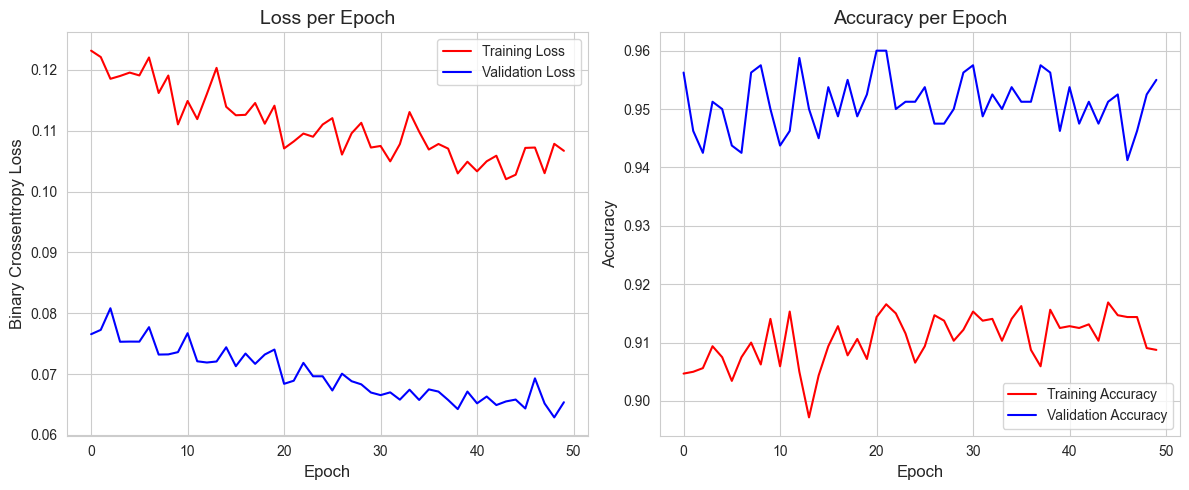

In [74]:
history = nn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.20,
    callbacks=[early_stop],
    verbose=1
)


sns.set_style("whitegrid")

train_color = "red"
val_color = "blue"

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(history.history['loss'], label='Training Loss', color=train_color)
axes[0].plot(history.history['val_loss'], label='Validation Loss', color=val_color)
axes[0].set_title('Loss per Epoch', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Binary Crossentropy Loss', fontsize=12)
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['accuracy'], label='Training Accuracy', color=train_color)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color=val_color)
axes[1].set_title('Accuracy per Epoch', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

In [75]:
def evaluate_multilabel(model, X_test, y_test, name):
    if hasattr(model, "predict_proba"):
        y_prob = np.column_stack([clf.predict_proba(X_test)[:, 1]
                                  for clf in model.estimators_])
    else:                                         
        dec = model.decision_function(X_test)
        y_prob = 1 / (1 + np.exp(-dec))           

    y_pred = (y_prob > 0.5).astype(int)

    metrics = {
        "model":          name,
        "F1-micro":       f1_score(y_test, y_pred, average="micro"),
        "F1-macro":       f1_score(y_test, y_pred, average="macro"),
        "ROC-AUC-micro":  roc_auc_score(y_test, y_prob, average="micro"),
        "ROC-AUC-macro":  roc_auc_score(y_test, y_prob, average="macro"),
        "Hamming loss":   hamming_loss(y_test, y_pred),
        "Exact-match":    accuracy_score(y_test, y_pred),
    }
    return metrics


rf_metrics  = evaluate_multilabel(rf_clf, X_test, y_test, "Random-Forest")

xgb_metrics = evaluate_multilabel(xgb_clf, X_test, y_test, "XGBoost")

y_prob_nn = nn_model.predict(X_test, verbose=0)
y_pred_nn = (y_prob_nn > 0.5).astype(int)
nn_metrics = {
    "model":          "Neural-Net",
    "F1-micro":       f1_score(y_test, y_pred_nn, average="micro"),
    "F1-macro":       f1_score(y_test, y_pred_nn, average="macro"),
    "ROC-AUC-micro":  roc_auc_score(y_test, y_prob_nn, average="micro"),
    "ROC-AUC-macro":  roc_auc_score(y_test, y_prob_nn, average="macro"),
    "Hamming loss":   hamming_loss(y_test, y_pred_nn),
    "Exact-match":    accuracy_score(y_test, y_pred_nn),
}

results_df = pd.DataFrame([rf_metrics, xgb_metrics, nn_metrics])
print("\n=== Multi-label performance on held-out test set ===")
display(results_df.round(3))



=== Multi-label performance on held-out test set ===


,model,F1-micro,F1-macro,ROC-AUC-micro,ROC-AUC-macro,Hamming loss,Exact-match
0,Random-Forest,0.949,0.946,0.998,0.997,0.021,0.934
1,XGBoost,0.971,0.966,0.999,0.999,0.012,0.951
2,Neural-Net,0.971,0.938,0.999,0.999,0.012,0.951


In [76]:
def analyse_multilabel(y_true, y_pred, class_names,
                       title_prefix="Model"):
    p, r, f1, s = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    df_report = (pd.DataFrame({
        "precision": p,
        "recall"   : r,
        "f1"       : f1,
        "support"  : s
    }, index=class_names)
      .round(3)
      .sort_values("support", ascending=False)
    )
    display(df_report.style.background_gradient(cmap="Blues"))

    cm_all = multilabel_confusion_matrix(y_true, y_pred)
    n_cols = 3                            
    n_lab  = len(class_names)
    n_rows = int(np.ceil(n_lab / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4*n_cols, 4*n_rows),
                             constrained_layout=True)

    axes = axes.flatten()
    for i, (cm, ax) in enumerate(zip(cm_all, axes)):
        if i >= n_lab:                     
            ax.axis("off");  continue
        tn, fp, fn, tp = cm.ravel()
        sns.heatmap([[tp, fp], [fn, tn]],
            annot=True, fmt="d", cbar=False,
            cmap="YlGnBu", ax=ax,
            annot_kws={"size": 19})   
        ax.set_title(class_names[i])
        ax.set_xlabel("Predicted");  ax.set_ylabel("Actual")
        ax.set_xticklabels(["Pos", "Neg"]);  ax.set_yticklabels(["Pos", "Neg"])

    fig.suptitle(f"{title_prefix} – per-label confusion matrices",
                 fontsize=14, y=1.02)
    plt.show()

    return df_report 


In [77]:
def ovr_proba_to_matrix(proba):
    if isinstance(proba, list):                            
        return np.column_stack([p[:, 1] for p in proba])
    else:                                                   
        return proba

,precision,recall,f1,support
Raider,0.967000,0.975000,0.971000,516
EvolvedANNNoise05,0.933000,0.924000,0.929000,303
GrudgerAlternator,0.951000,0.916000,0.933000,107
Forgiver,0.951000,0.846000,0.895000,91
Cooperator,1.000000,1.000000,1.000000,29


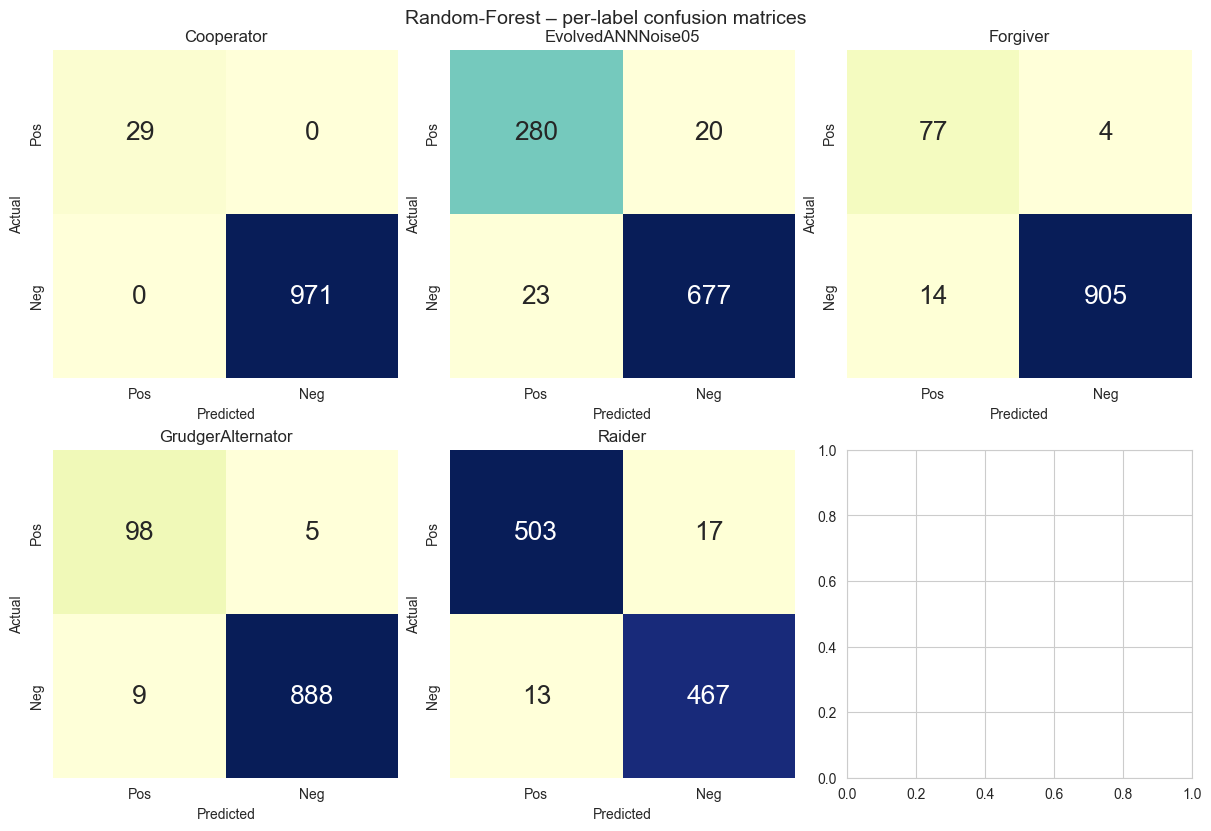

,precision,recall,f1,support
Raider,0.967,0.975,0.971,516
EvolvedANNNoise05,0.933,0.924,0.929,303
GrudgerAlternator,0.951,0.916,0.933,107
Forgiver,0.951,0.846,0.895,91
Cooperator,1.000,1.000,1.000,29


In [78]:
# -------------------------------------------------------
# Random Forest
# -------------------------------------------------------
y_prob_rf = ovr_proba_to_matrix(rf_clf.predict_proba(X_test))
y_pred_rf = (y_prob_rf > 0.5).astype(int)

analyse_multilabel(y_test, y_pred_rf, mlb.classes_,
                   title_prefix="Random-Forest")

,precision,recall,f1,support
Raider,0.986000,0.979000,0.982000,516
EvolvedANNNoise05,0.954000,0.960000,0.957000,303
GrudgerAlternator,0.971000,0.935000,0.952000,107
Forgiver,1.000000,0.945000,0.972000,91
Cooperator,0.966000,0.966000,0.966000,29


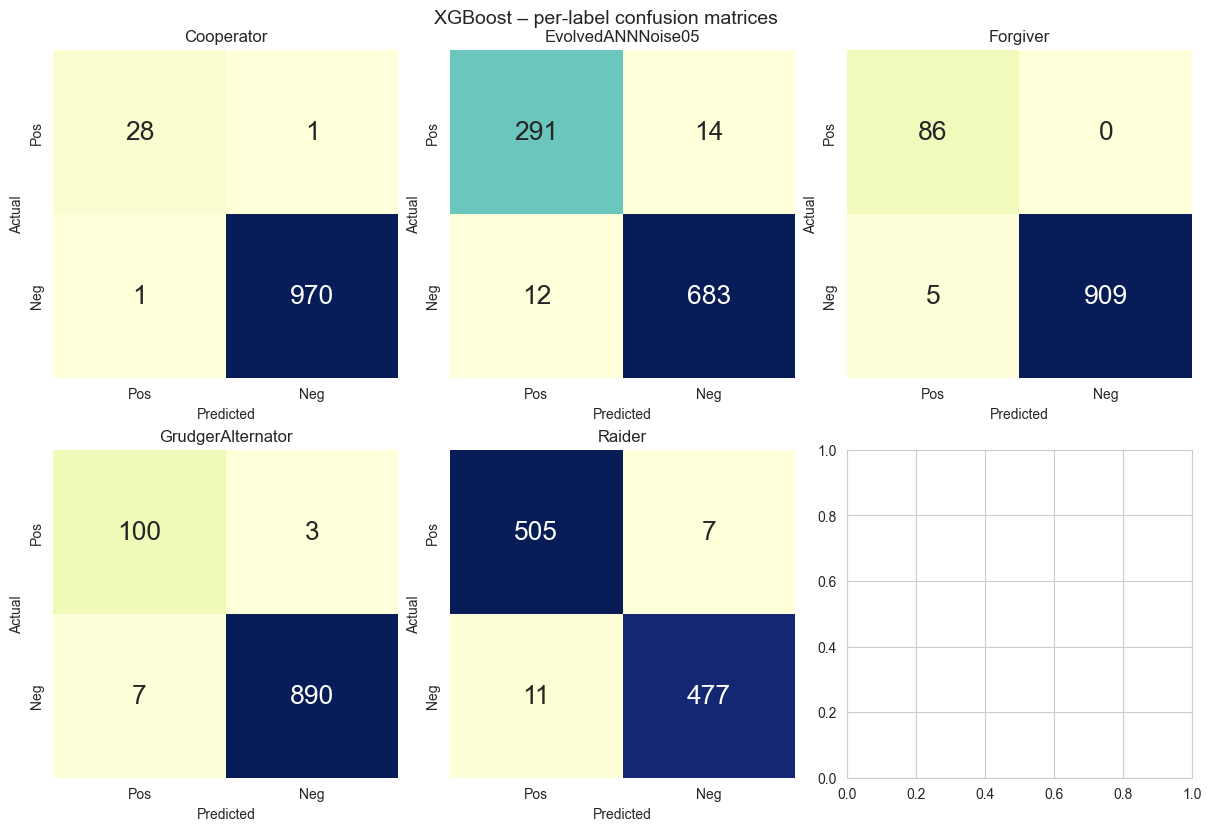

,precision,recall,f1,support
Raider,0.986,0.979,0.982,516
EvolvedANNNoise05,0.954,0.960,0.957,303
GrudgerAlternator,0.971,0.935,0.952,107
Forgiver,1.000,0.945,0.972,91
Cooperator,0.966,0.966,0.966,29


In [79]:
# -------------------------------------------------------
# XGBoost
# -------------------------------------------------------
y_prob_xgb = ovr_proba_to_matrix(xgb_clf.predict_proba(X_test))
y_pred_xgb = (y_prob_xgb > 0.5).astype(int)

analyse_multilabel(y_test, y_pred_xgb, mlb.classes_,
                   title_prefix="XGBoost")

,precision,recall,f1,support
Raider,0.988000,0.990000,0.989000,516
EvolvedANNNoise05,0.990000,0.980000,0.985000,303
GrudgerAlternator,0.959000,0.869000,0.912000,107
Forgiver,0.952000,0.879000,0.914000,91
Cooperator,0.960000,0.828000,0.889000,29


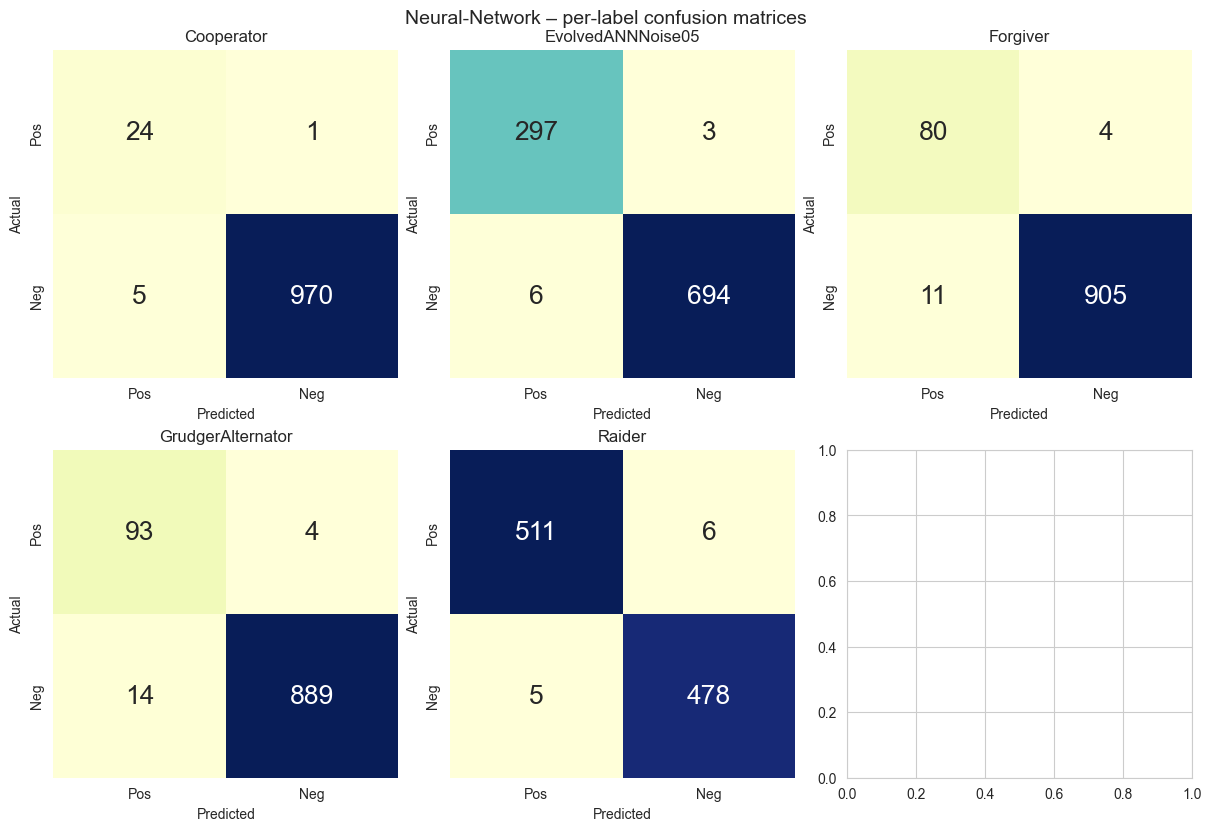

,precision,recall,f1,support
Raider,0.988,0.990,0.989,516
EvolvedANNNoise05,0.990,0.980,0.985,303
GrudgerAlternator,0.959,0.869,0.912,107
Forgiver,0.952,0.879,0.914,91
Cooperator,0.960,0.828,0.889,29


In [80]:
y_prob_nn = nn_model.predict(X_test, verbose=0)
y_pred_nn = (y_prob_nn > 0.5).astype(int)

analyse_multilabel(y_test, y_pred_nn, mlb.classes_,
                   title_prefix="Neural-Network")